In [1]:
# Script to plot logistic and gompertz fits to observations diseased people in a variety of countries
# Fits are performed with non-linear least squares and plotted in time using Runge-Kutta using the 
# Ordinary differential equations for both logistic and Gompertz.

import requests
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from numpy import log
import scipy.optimize as spo
from scipy import integrate

# Define some convenience functions
def sird(x, gamma=1, eta=1, beta=1):
    return gamma*(1 - np.exp(- eta * x)) - beta*x
def sird_jac(x, gamma, eta, beta):
    J = np.empty((x.size, 3))
    J[:, 0] = 1 - np.exp(-eta*x)
    J[:, 1] = gamma*x*np.exp(-eta*x)
    J[:, 2] = -x
    return J
def logistic(x, b, k):
    return b * x * (1 - x / k)

def get_b_k(gamma, eta, beta):
    b = gamma*eta - beta
    k = gamma * eta**2/(2*b)
    return b, k
def d_small(x, gamma=1, eta=1, beta=1):
    b,k = get_b_k(gamma, eta, beta)
    return b*x*(1-k*x)
def gomp(x, beta=1, alpha=1, x_tilde=1):
    return beta*x - alpha*x*np.log((x + 0.0001) / x_tilde)
def gomp_jac(x, beta, alpha, x_tilde):
    J = np.empty((x.size, 3))
    J[:, 0] = x
    J[:, 1] = -x*np.log(x/x_tilde)
    J[:, 2] = alpha*x/x_tilde
    return J
def get_gomp_inf(beta, alpha, x_tilde):
    return x_tilde * np.exp(beta / alpha)
def gomp_time(t, x0, beta, alpha, x_tilde):
    xinf = get_gomp_inf(beta, alpha, x_tilde)
    gamma = x0 / xinf
    return xinf * np.power(gamma, np.exp(- alpha * t))
def gomp_norm(lns, alpha):
    return - alpha * lns
def get_transmission_rate(gamma, eta, cov):
    # source: https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables#Correlated_central-normal_distributions
    # cov is in order gamma, eta, beta
    # from Carletti's definition and the SIRD here
    # returns rate and standard error
    transmission_rate = eta * gamma
    rho = cov[0, 1]
    gamma_var = cov[0, 0]
    eta_var = cov[1, 1]
    var_transmission = gamma_var * eta_var * (1 + rho**2) + eta_var*(gamma**2) + gamma_var * (eta**2) 
    return transmission_rate, np.sqrt(var_transmission)
    
def gomp_fit(t, yraw):
    y = np.copy(yraw)
    yinf = np.max(y)
    y = y / yinf
    lly = safe_lnln(y)
    interp = np.ones(len(lly))
    np.linalg.lstsq()
    

def sirdODE(t, y, r, a, d, s0):
    S, I, R, D = y
    Sp = -r/s0 * S * I
    Ip = r/s0 * S * I - (a + d) * I
    Rp = a * I
    Dp = d * I
    yp = Sp, Ip, Rp, Dp
    return yp

def sird_d_ODE(t, y, gamma=1, eta=1, beta=1):
    # Deaths only
    yp = sird(y, gamma, eta, beta)
    return yp

def sird_dsmall_ODE(t, y, gamma=1, eta=1, beta=1):
    # Deaths only
    yp = d_small(y, gamma, eta, beta)
    return yp

def safe_lnln(x, k=1):
    z = x / k
    eps = 1e-5
    z[z == 0] = eps
    z[z >= 1.] = 1- eps
    return np.log(-np.log(z))

def sird_d_time(t, x0, gamma, eta, beta, norm=False):
    tmax = np.max(t)
    
    obj = integrate.solve_ivp(sird_d_ODE, (0, tmax), (x0,), 
                              t_eval=np.arange(tmax + 1), args=(gamma, eta, beta))
    d_sird = obj["y"].flatten()
    if norm:
        d_sird = d_sird / d_sird.max()
    return d_sird

def sird_dsmall_time(t, x0, gamma, eta, beta, norm=False):
    tmax = np.max(t)
    
    obj = integrate.solve_ivp(sird_dsmall_ODE, (0, tmax), (x0,), 
                              t_eval=np.arange(tmax + 1), args=(gamma, eta, beta))
    d_sird = obj["y"].flatten()
    if norm:
        d_sird = d_sird / d_sird.max()
    return d_sird

def logistic_time(t, x0, b, k):
    tmax = np.max(t)
    A = (k - x0) / x0
    denom =1 + A * np.exp(-b*t) 

    return k/denom

def sird_time(t, dx0, x0, mu, gamma, eta, beta, xinf=1, norm=False):
    # mu is recovery / death ratio
    tmax = np.max(t)
    d, r = mu * beta, eta * gamma
    s0 = gamma / d
    
    i0 = dx0 / d
    r0 = mu * x0
    a = beta - d
    y0 = s0, i0, r0, x0
    print(f"d: {d:.3f},a:{a:.3f},r:{r:.2f}")
#     print(f"Implied s0: {s0:.3f}")
#     print(f"initial slope: {gamma * eta - beta}")
    obj = integrate.solve_ivp(sirdODE, (0, tmax), y0, 
                              t_eval=np.arange(tmax + 1), args=(r, a, d, s0))
    d_sird = obj["y"][3, :]
#     from pdb import set_trace
#     set_trace()
    if norm:
        d_sird = obj["y"][3, :] / obj["y"][3, :].max()
    return d_sird, d, a, r, obj

START_DATE = "2020-01-22"
END_DATE = "2020-05-16"
WINDOW = 6 # days

# Primary data source
def get_data2(country):
    y = data2[data2["Country/Region"] == country].iloc[:, 4:].sum(axis=0)
    dates = pd.to_datetime(data2.columns[4:], format="%m/%d/%y")
    cumdeaths = pd.Series(index=dates[1:], data=y.values.flatten()[1:])
    deaths = pd.Series(index=dates[1:], data=np.diff(y.values.flatten()))
    if country == "China":
        deaths = deaths[~((deaths > 1000))]
    cumdeaths = deaths.cumsum()
    deaths = deaths.rolling(WINDOW, center=True).mean()
    country = pd.DataFrame(index=dates[1:], data={"rollDeaths": deaths, "cumDeaths": cumdeaths})
    country = country[START_DATE:END_DATE]
    country = country.dropna()
    return country

# Alternative data source (obsolete)
def get_data(country: str):

    country = data[data.countriesAndTerritories == country]
    country.index = pd.to_datetime(country.dateRep, format="%d/%m/%Y")
    country = country.sort_index()
    country = country[START_DATE:END_DATE]
    country["rollDeaths"] = country.deaths.rolling(WINDOW, center=True).mean()
    country["cumDeaths"] = country.rollDeaths.cumsum()
    country["rollDeathsNorm"] = country["rollDeaths"] / country["cumDeaths"].max()
    country["cumDeathsNorm"] = country["cumDeaths"] / country["cumDeaths"].max()
    country = country.dropna()
    return country

# Conversion of numbers and errors to strings with uncertainty 
# e.g. value=1.002, error=0.3 => 1.0(3)
def conv2siunitx(val, err, err_points=1, si=True):
    value = f'{val:.20e}'.split('e')
    error = f'{err:.20e}'.split('e') 
    val, val_exp = float(value[0]), int(value[1])
    err, err_exp = float(error[0]), int(error[1])
    diff = val_exp - err_exp
    my_val = f'{np.round(val, diff):.10f}'
    my_err = f'{np.round(err, err_points-1):.10f}'.replace('.','')

    if not si:
        c = np.power(10, float(val_exp))
        num = np.round(val, diff) * c
        my_val = f'{num:.10f}'
        
        if err_exp > 0: # Account for more digits in errors > 10
            err_points += err_exp

        if err_exp >= 0 and val_exp > 0:
            first_uncertain = abs(val_exp) + 1
        if err_exp < 0 and val_exp < 0:
            first_uncertain = abs(val_exp) + 2 + diff
        if err_exp < 0 and val_exp > 0:
            first_uncertain = val_exp + abs(err_exp) + 2
        if val_exp == 0 and err_exp < 0:
            first_uncertain = diff + 2
        if err_exp >= 0 and val_exp == 0:
            first_uncertain = 1
        val_exp = ""
    else:
        val_exp = f"e{val_exp}"            
        if val_exp == "e+00":
            val_exp = ''
            
    return(f'{my_val[:first_uncertain]}({my_err[:err_points]}){val_exp}')

assert conv2siunitx(980, 70, si=False) == "980(70)"
assert conv2siunitx(980, 73, si=False) == "980(70)"
assert conv2siunitx(9802, 731, si=False) == "9800(700)"
assert conv2siunitx(0.02, 0.003, si=False) == "0.020(3)"
assert conv2siunitx(1.0321, 0.0003, si=False) == '1.0321(3)'
assert conv2siunitx(9802, 0.731, si=False) == "9802.0(7)"
assert conv2siunitx(2, 1, si=False) == "2(1)"
assert conv2siunitx(937.697300, 80, si=False) == "940(80)"


In [2]:
# Data source
# Extract from https://github.com/CSSEGISandData/COVID-19
url2 = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
# Extract data from ECDC: https://www.ecdc.europa.eu/en/publications-data/data-daily-new-cases-covid-19-eueea-country
url_alternative = "https://opendata.ecdc.europa.eu/covid19/nationalcasedeath_eueea_daily_ei/csv/data.csv"

In [3]:
data2 = pd.read_csv(url2)
data2.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/18/22,4/19/22,4/20/22,4/21/22,4/22/22,4/23/22,4/24/22,4/25/22,4/26/22,4/27/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,7679,7680,7680,7680,7680,7681,7682,7683,7683,7683
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,6874,6874,6874,6874,6874,6874,6875,6875,6875,6875
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,153,153,153,153,153,153,153,153,153,153
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,1900,1900,1900,1900,1900,1900,1900,1900,1900,1900


In [4]:
# Not used, but could be used as an alternative data source
# data = pd.read_csv(url)
# data.head()
# countries = data.countriesAndTerritories.unique()
# countries

In [5]:
data2["Country/Region"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Gua

2020-01-26      40.0
2020-01-27      66.0
2020-01-28     115.0
2020-01-29     117.0
2020-01-30     155.0
               ...  
2020-05-12    3331.0
2020-05-13    3331.0
2020-05-14    3331.0
2020-05-15    3331.0
2020-05-16    3332.0
Name: cumDeaths, Length: 111, dtype: float64

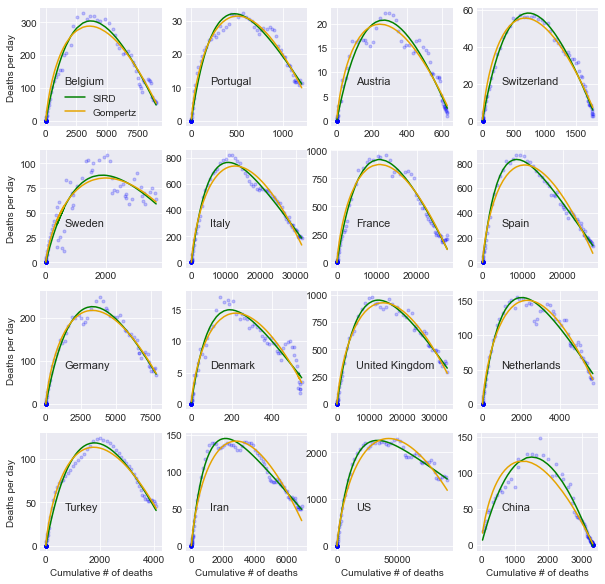

In [6]:
plt.rcParams['text.usetex'] = False
plt.style.use('seaborn-darkgrid')
f, axs = plt.subplots(4,4,figsize=(10,10))
subset = ['Belgium', 'Portugal',  'Austria', 
       'Switzerland', 'Sweden',  'Italy', 'France', 'Spain', 'Germany','Denmark', 
          "United Kingdom", 'Netherlands', "Turkey", "Iran", "US", "China"]

popt_orig = {}
pcov_orig = {}
popt_gomp_country = {}
popt_orig_gomp = {}
pcov_orig_gomp = {}
maxd = {}
for n, country in enumerate(subset):
    if n > 15:
        break
    i = int(n / 4)
    j = n % 4
    plt.sca(axs[i, j])
    country_data = get_data2(country)
    x, y = country_data.cumDeaths + 1, country_data.rollDeaths
    maxd[country] = np.max(x)
    sird_min_params = (10, 1e-6, 0.001) # gamma, eta, beta
    sird_max_params = (10000, 1e-2, 1)
    gomp_min_params = (0.01, 0.001, 0.01) # beta, alpha, x_tilde
    gomp_max_params = (10, 1., 1.)


    popt_orig[country], pcov_orig[country] = spo.curve_fit(sird, x, y, bounds=(sird_min_params, sird_max_params),
                                                          jac=sird_jac, method="trf")
    popt_orig_gomp[country], pcov_orig_gomp[country] = spo.curve_fit(gomp, x, y, bounds=(gomp_min_params, gomp_max_params),
                                                          jac=gomp_jac)
    gamma, eta, beta = popt_orig[country]
    r0 = np.round(eta * gamma / beta, 1)
    plt.plot(x, y, ".", color="#0000ff", alpha=0.2)
    plt.plot(x, sird(x, *popt_orig[country]), label="SIRD", color="#008000")
    plt.plot(x, gomp(x, *popt_orig_gomp[country]), label="Gompertz", color="#e5a400")
    xmin, xmax = axs[i, j].get_xlim()
    ymin, ymax = axs[i, j].get_ylim()
    x_alpha = 0.80
    y_alpha = 0.65
    
    xloc = xmin * x_alpha + xmax * (1-x_alpha)
    yloc = ymin * y_alpha + ymax * (1-y_alpha)
    plt.text(xloc, yloc, country, fontsize=11)
#     plt.text(xloc, yloc * 0.5, r0, fontsize=11)
    if j == 0:
        plt.ylabel("Deaths per day")
    if i == 3:
        plt.xlabel("Cumulative # of deaths")
    if n == 0:
        plt.legend()
# plt.savefig("../figures/Gompertz_vs_SIRD.pdf")


d: 0.001,a:0.092,r:0.30
d: 0.001,a:0.044,r:0.23
d: 0.001,a:0.111,r:0.30
d: 0.001,a:0.109,r:0.30
d: 0.000,a:0.034,r:0.16
d: 0.000,a:0.037,r:0.24
d: 0.001,a:0.080,r:0.30
d: 0.001,a:0.047,r:0.33
d: 0.001,a:0.064,r:0.24
d: 0.001,a:0.042,r:0.26
d: 0.001,a:0.043,r:0.25
d: 0.001,a:0.042,r:0.26
d: 0.001,a:0.068,r:0.23
d: 0.000,a:0.025,r:0.23
d: 0.000,a:0.018,r:0.24
d: 0.003,a:0.257,r:0.44


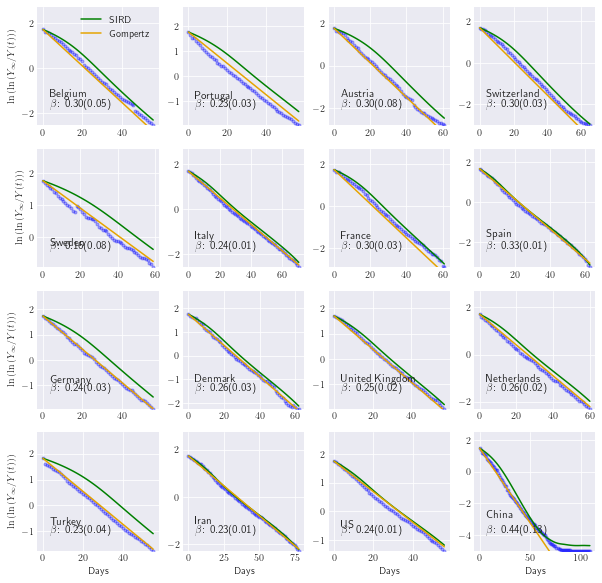

In [9]:
# Parameters estimated with normalized observations
plt.rcParams['text.usetex'] = True
f, axs = plt.subplots(4,4,figsize=(10,10))
subset = ['Belgium', 'Portugal',  'Austria',
       'Switzerland', 'Sweden',  'Italy', 'France', 'Spain', 'Germany','Denmark', 
          "United Kingdom", 'Netherlands', "Turkey", "Iran", "US", "China"]
m = len(subset)
inflation = 2
popt_gomp = {}
popt = {}
xinf = {}
pcov = {}
pcov_gomp = {}
d, a, r, r_sd = np.zeros(m), np.zeros(m), np.zeros(m), np.zeros(m)
for n, country in enumerate(subset):
    if n > 15:
        break
    i = int(n / 4)
    j = n % 4
    plt.sca(axs[i, j])
    country_data = get_data2(country)
    x, y = country_data.cumDeaths + 1, country_data.rollDeaths
    maxd[country] = np.max(x)
    x, y = x / np.max(x), y / np.max(x)
    t0 = max(min(np.arange(len(x))[x/x.max() > 0.005]) - 1, 0)
    x, y = x[t0:], y[t0:] 
    t = np.arange(np.maximum(50, len(x) - 1))
    popt[country], pcov[country] = spo.curve_fit(sird, x, y, jac=sird_jac)
    popt_gomp[country], pcov_gomp[country] = spo.curve_fit(gomp, x.values, y.values, 
                                                           bounds=(gomp_min_params, gomp_max_params),
                                                          jac=gomp_jac)
    xinf[country] = get_gomp_inf(*popt_gomp[country])

    gamma, eta, beta = popt[country]
    slope_i = np.round(gamma * eta - beta, 2)
    mu, var_mu = 0.012, 0.005**2 # death / (death + recovery) ratio
    dx0 = (x[1] - x[0] + x[2] - x[1]) / 2
#     dx0 = (x[1] - x[0])
    r[n], r_sd[n] = get_transmission_rate(gamma, eta, pcov[country])
    _, d[n], a[n], _, _ = sird_time(t, dx0, x[1], mu, *popt[country], norm=False)
    D_sird = maxd[country] * sird_d_time(t, x[0], *popt[country])
#     print(get_b_k(*popt[country]))
#     D_sird = sird_d_time(t, x[0], *popt[country])
    D_gomp = maxd[country] * gomp_time(t, x[0], *popt_gomp[country])
    ll = safe_lnln(x[t], xinf[country])
    plt.plot(t, ll, ".", color="#0000ff", alpha=0.3)
    plt.plot(t, safe_lnln(D_sird, xinf[country]*maxd[country]), label="SIRD", color="#008000")
    plt.plot(t, safe_lnln(D_gomp, xinf[country]*maxd[country]), label="Gompertz", color="#e5a400")
#     plt.plot(t, safe_lnln(D_sird), label="SIRD", color="#008000")
#     plt.plot(t, safe_lnln(D_gomp), label="Gompertz", color="#e5a400")

    axs[i, j].set_ylim((np.min(ll), np.max(ll) + 1))
    xmin, xmax = axs[i, j].get_xlim()
    ymin, ymax = axs[i, j].get_ylim()
    x_alpha = 0.90
    y_alpha = 0.85

    xloc = xmin * x_alpha + xmax * (1-x_alpha)
    yloc = ymin * y_alpha + ymax * (1-y_alpha)
    plt.text(xloc, yloc * 0.75, country, fontsize=11)
    plt.text(xloc, yloc, r"$\beta$: " + f"{r[n]:.2f}({r_sd[n]:.2f})", fontsize=11)
    if j == 0:
        plt.ylabel(r"$\ln{(\ln{(Y_{\infty}/Y(t))})}$")
    if i == 3:
        plt.xlabel("Days")
    if n == 0:
        plt.legend(loc="upper right")
plt.savefig("../figures/Gompertz_vs_SIRD_lnln_infty.pdf")

In [ ]:
# Print latex tables of parameter estimates with uncertainties

sd_df = pd.DataFrame({c:np.sqrt(np.diag(m)) for c, m in pcov.items()}, index=["gamma", "eta", "beta"]).T
est = pd.DataFrame(popt, index=["gamma", "eta", "beta"]).T
gomp_param_names = ["beta", "alpha", "x_tilde"]
sd_gomp_df = pd.DataFrame({c:np.sqrt(np.diag(m)) for c, m in pcov_gomp.items()}, index=gomp_param_names).T
est_gomp = pd.DataFrame(popt_gomp, index=gomp_param_names).T
est_sd = np.zeros_like(est.values, dtype='U16')
est_sd_gomp = np.zeros_like(est.values, dtype='U16')
sird_factor = [1e1, 1, 1e2]
gomp_factor = [1e1, 1e2, 1e2]
for i, row in enumerate(est.iterrows()):
    index, value = row
    for j, entry in enumerate(value.iteritems()):
        index, value = entry
        est_sd[i,j] = conv2siunitx(est.iloc[i,j]*sird_factor[j], sd_df.iloc[i,j]*sird_factor[j], si=False)
        est_sd_gomp[i,j] = conv2siunitx(est_gomp.iloc[i,j]*gomp_factor[j], sd_gomp_df.iloc[i,j]*gomp_factor[j], si=False)

est_sd = pd.DataFrame(est_sd, index=est.index, columns=est.columns)
est_sd_gomp = pd.DataFrame(est_sd_gomp, index=est_gomp.index, columns=est_gomp.columns)
print(est_sd.to_latex())
print(est_sd_gomp.to_latex())


In [ ]:
# Original scale
gomp_param_names = ["beta", "alpha", "x_tilde"]
sird_param_names = ["gamma", "eta", "beta"]
sd_df = pd.DataFrame({c:np.sqrt(np.diag(m)) for c, m in pcov_orig.items()}, index=sird_param_names).T
est = pd.DataFrame(popt_orig, index=sird_param_names).T
sd_gomp_df = pd.DataFrame({c:np.sqrt(np.diag(m)) for c, m in pcov_orig_gomp.items()}, index=gomp_param_names).T
est_gomp = pd.DataFrame(popt_orig_gomp, index=gomp_param_names).T
est_sd = np.zeros_like(est.values, dtype='U16')
est_sd_gomp = np.zeros_like(est.values, dtype='U16')
sird_factor = [1e-1, 1e4, 1e2]
gomp_factor = [1e1, 1e2, 1e2]
for i, row in enumerate(est.iterrows()):
    index, value = row
    for j, entry in enumerate(value.iteritems()):
        index, value = entry
        est_sd[i,j] = conv2siunitx(est.iloc[i,j]*sird_factor[j], sd_df.iloc[i,j]*sird_factor[j], si=False)
        est_sd_gomp[i,j] = conv2siunitx(est_gomp.iloc[i,j]*gomp_factor[j], sd_gomp_df.iloc[i,j]*gomp_factor[j], si=False)

est_sd = pd.DataFrame(est_sd, index=est.index, columns=est.columns)
est_sd_gomp = pd.DataFrame(est_sd_gomp, index=est_gomp.index, columns=est_gomp.columns)
print(est_sd.to_latex())
print(est_sd_gomp.to_latex())

In [ ]:
# Estimates of the SIRD coefficients 
# d: rate of dying
# a: rate of recovery
# r: rate of transmission
pd.DataFrame({"d":d, "a":a, "r":r}, index=subset)

In [ ]:
#Fit gompertz with a straight line in the double-log domain
plt.rcParams['text.usetex'] = True
f, axs = plt.subplots(4,4,figsize=(10,10))
subset = ['Belgium', 'Portugal',  'Austria',
       'Switzerland', 'Sweden',  'Italy', 'France', 'Spain', 'Germany','Denmark', 
          "United Kingdom", 'Netherlands', "Turkey", "Iran", "US", "China"]
m = len(subset)
inflation = 2
popt_gomp = {}
popt = {}
maxd = {}

max_t_in_fit = 42
CUTOFF = 0.005
d, a, r, r_sd = np.zeros(m), np.zeros(m), np.zeros(m), np.zeros(m)
for n, country in enumerate(subset):
    if n > 15:
        break
    i = int(n / 4)
    j = n % 4
    plt.sca(axs[i, j])
    country_data = get_data2(country)
    x, y = country_data.cumDeaths + 1, country_data.rollDeaths
    maxd[country] = np.max(x)
    t = np.arange(np.maximum(50, len(x) - 1))
    x, y = x[t] / np.max(x[t]), y[t] / np.max(x[t])
    t0 = max(min(np.arange(len(x))[x > CUTOFF]) - 1, 0)
#     x, y = x[t0:(t0 + tmax)], y[t0:(t0 + tmax)] 
#     print(min(np.arange(len(x))[x > CUTOFF]) - 1)
    x, y = x[t0:], y[t0:] 
    ll = safe_lnln(x)
    t = np.arange(len(ll))
    ones = np.ones(len(ll))
    pred = np.vstack([ones, t]).T[:max_t_in_fit, :]
    a, b = np.linalg.lstsq(pred, ll[:max_t_in_fit], rcond=None)[0]
    
    # Uncomment to use fixed intercept and thus a one-parameter model
    a = np.log(-np.log(x[0]))
    b = np.linalg.lstsq(t[None, :max_t_in_fit].T, ll[:max_t_in_fit] - a, rcond=None)[0]
    
    popt[country], pcov = spo.curve_fit(sird, x, y)
#     popt_gomp[country], pcov_gomp = spo.curve_fit(gomp, x, y, bounds=(gomp_min_params, gomp_max_params))
    
    r[n], r_sd[n] = get_transmission_rate(gamma, eta, pcov)
    D_sird = maxd[country] * sird_d_time(t, x[0], *popt[country])
    D_gomp = maxd[country] * np.exp(-np.exp(a + b*t))
#     D_sird = sird_d_time(t, x[0], *popt[country])
#     D_gomp = np.exp(-np.exp(a + b*t))
#     D_sird = xinf[country] * sird_d_time(t, x[0], *popt[country])
#     D_gomp = maxd[country] * np.exp(-np.exp(a + b*t))

    
    plt.plot(t, ll, ".", color="#0000ff", alpha=0.3)
#     plt.plot(t, safe_lnln(D_sird, np.max(D_sird)), label="SIRD", color="#008000")
#     plt.plot(t, safe_lnln(D_gomp, np.max(D_gomp)), label="Gompertz", color="#e5a400")
#     plt.plot(t, safe_lnln(D_sird), label="SIRD", color="#008000")
#     plt.plot(t, safe_lnln(D_gomp), label="Gompertz", color="#e5a400")
    plt.plot(t, safe_lnln(D_sird, maxd[country]), label="SIRD", color="#008000")
    plt.plot(t, safe_lnln(D_gomp, maxd[country]), label="Gompertz", color="#e5a400")

    axs[i, j].set_ylim((ll[-3], np.max(ll) + 1))
    xmin, xmax = axs[i, j].get_xlim()
    ymin, ymax = axs[i, j].get_ylim()
    x_alpha = 0.90
    y_alpha = 0.85

    xloc = xmin * x_alpha + xmax * (1-x_alpha)
    yloc = ymin * y_alpha + ymax * (1-y_alpha)
    plt.text(xloc, yloc * 0.75, country, fontsize=11)
# #     plt.text(xloc, yloc, r"$r$: " + f"{r[n]:.2f}({r_sd[n]:.2f})", fontsize=11)
    if j == 0:
        plt.ylabel(r"$\ln{(\ln{(Y_{max}/Y(t))})}$")
    if i == 3:
        plt.xlabel("Days")
    if n == 0:
        plt.legend(loc="upper right")
# plt.savefig("../figures/Gompertz_vs_SIRD_linear_gompfit_one_param.pdf")

In [ ]:
xinf[country]

In [ ]:
# Appendix: Cumulative deaths vs. time
plt.rcParams['text.usetex'] = False
f, axs = plt.subplots(4,4,figsize=(10,10))
subset = ['Belgium', 'Portugal',  'Austria', 
       'Switzerland', 'Sweden',  'Italy', 'France', 'Spain', 'Germany','Denmark', 
          "United Kingdom", 'Netherlands', "Turkey", "Iran", "US", "China"]

inflation = 1.6
popt_gomp = {}
popt = {}
m = len(subset)
d, a, r = np.zeros(m), np.zeros(m), np.zeros(m)
for n, country in enumerate(subset):
    if n > 15:
        break
    i = int(n / 4)
    j = n % 4
    plt.sca(axs[i, j])
    country_data = get_data2(country)
    x, y = country_data.cumDeaths + 1, country_data.rollDeaths
    maxd[country] = np.max(x)
    x, y = x / np.max(x), y / np.max(x)
    t0 = max(min(np.arange(len(x))[x/x.max() > 0.005]) - 1, 0)
    x, y = x[t0:], y[t0:] 
    t = np.arange(np.maximum(50, len(x) - 1))
    popt[country], _ = spo.curve_fit(sird, x, y)
    popt_gomp[country], _ = spo.curve_fit(gomp, x, y, bounds=(gomp_min_params, gomp_max_params))
    gamma, eta, beta = popt_country[country]

    mu = 0.012 # death / (death + recovery) ratio
    dx0 = (x[1] - x[0] + x[2] - x[1]) / 2
    D_sird, d[n], a[n], r[n], obj = sird_time(t, dx0, x[0], mu, *popt[country])
    D_gomp = gomp_time(t, x[0], *popt_gomp[country])
    
    plt.plot(t, x[t], ".", color="#0000ff", alpha=0.3)
    plt.plot(t, D_sird, label="SIRD", color="#008000")
    plt.plot(t, D_gomp, label="Gompertz", color="#e5a400")

    xmin, xmax = axs[i, j].get_xlim()
    ymin, ymax = axs[i, j].get_ylim()
    x_alpha = 0.80
    y_alpha = 0.65

    xloc = xmin * x_alpha + xmax * (1-x_alpha)
    yloc = ymin * y_alpha + ymax * (1-y_alpha)
    plt.text(xloc, yloc, country, fontsize=11)
#     plt.text(xloc, yloc * 0.5, r0, fontsize=11)
    if j == 0:
        plt.ylabel("Cumulative # of deaths")
    if i == 3:
        plt.xlabel("Days")
    if n == 0:
        plt.legend()
# plt.savefig("../figures/Gompertz_vs_SIRD_time.pdf")